# FaIR with input data
## Goal: Learn how to run FaIR with input data
This notebook uses EDGAR CO2 observations (1970-2022)
### Erica Simon, 01/22/2024




In [177]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

### Create instance

In [178]:
f = FAIR(ghg_method='leach2021')

### Define time horizon

In [179]:
f.define_time(1970, 2023, 1)

### Define scenarios

In [180]:
f.define_scenarios(['s1'])

### Define configs

In [181]:
f.define_configs(['c1'])

### Define species

In [182]:
# for now, trying only CO2 to see if it's possible to use CO2 eq for all GHG forcing agents
species = ['CO2']

In [183]:
properties = {
    'CO2': {
        'type': 'co2',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False,
    }}

In [184]:
f.define_species(species, properties)

### Create input and output data

In [185]:
# create empty emission and temp arrays
f.allocate()   

### Fill in the data
1. emissions/concentrations
2. initial conditions
3. climate_configs
4. species_configs

#### emissions/concentrations

In [186]:
co2_data = pd.read_csv("~/data/IEA_EDGAR_CO2_1970_2022.csv", index_col="Year")

The EDGAR data is in units of Gg CO2/yr, and FaIR takes units of Gt CO2/yr, so we need to make the conversion.

*1 ton = 1 million grams*

In [187]:
co2_data = co2_data / 1000000

In [188]:
co2_np = co2_data.to_numpy()
co2_np

array([[15.825428, 15.791981, 16.595636, 17.571714, 17.501571, 17.450419,
        18.448008, 19.008075, 19.50879 , 20.04775 , 19.788048, 19.422676,
        19.169208, 19.307241, 19.926542, 20.185812, 20.541712, 21.190601,
        21.946997, 22.333218, 22.516776, 22.654819, 22.564265, 22.672047,
        22.891595, 23.558161, 24.014919, 24.484309, 24.642505, 24.821891,
        25.621005, 25.938844, 26.344013, 27.562255, 28.846464, 29.9246  ,
        30.943465, 32.112597, 32.307311, 31.897679, 33.848414, 34.911315,
        35.380008, 36.066771, 36.290322, 36.158867, 36.256053, 36.890306,
        37.831881, 37.824922, 35.944484, 38.082177, 38.522011]])

In [189]:
print(co2_np.shape)
print(f.emissions.shape)

(1, 53)
(53, 1, 1, 1)


In [190]:
# need to reshape to fit emissions df
co2_np = np.reshape(co2_np, (53,1))
co2_np.shape

(53, 1)

In [191]:
fill(f.emissions, co2_np, scenario='s1', specie='CO2')

#### initial conditions

In [192]:
initialise(f.concentration, 325, specie='CO2')   # taken from EU EEA
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

#### climate configs

In [193]:
fill(f.climate_configs["ocean_heat_transfer"], [1.1, 1.6, 0.9])
fill(f.climate_configs["ocean_heat_capacity"], [8, 14, 100])
fill(f.climate_configs["deep_ocean_efficacy"], 1.1)

In [194]:
f.climate_configs

<xarray.Dataset>
Dimensions:                (config: 1, layer: 3)
Coordinates:
  * config                 (config) <U2 'c1'
  * layer                  (layer) int64 0 1 2
Data variables:
    ocean_heat_transfer    (config, layer) float64 1.1 1.6 0.9
    ocean_heat_capacity    (config, layer) float64 8.0 14.0 100.0
    deep_ocean_efficacy    (config) float64 1.1
    stochastic_run         (config) bool False
    sigma_eta              (config) float64 0.5
    sigma_xi               (config) float64 0.5
    gamma_autocorrelation  (config) float64 2.0
    seed                   (config) uint32 0
    use_seed               (config) bool False
    forcing_4co2           (config) float64 8.0

#### species configs

In [195]:
# fill with default values
f.fill_species_configs()

In [196]:
f.species_configs

<xarray.Dataset>
Dimensions:                                   (config: 1, specie: 1, gasbox: 4)
Coordinates:
  * config                                    (config) <U2 'c1'
  * specie                                    (specie) <U3 'CO2'
  * gasbox                                    (gasbox) int64 0 1 2 3
Data variables: (12/31)
    tropospheric_adjustment                   (config, specie) float64 0.05
    forcing_efficacy                          (config, specie) float64 1.0
    forcing_temperature_feedback              (config, specie) float64 0.0
    forcing_scale                             (config, specie) float64 1.0
    partition_fraction                        (config, specie, gasbox) float64 ...
    unperturbed_lifetime                      (config, specie, gasbox) float64 ...
    ...                                        ...
    aci_shape                                 (config, specie) float64 0.0
    cl_atoms                                  (specie) float64 0.0
    br_atoms                                  (specie) float64 0.0
    fractional_release                        (config, specie) float64 0.0
    ch4_lifetime_chemical_sensitivity         (config, specie) float64 0.0
    lifetime_temperature_sensitivity          (config) float64 -0.0408

### Run

In [199]:
f.run()

Running 1 projections in parallel:   0%|          | 0/53 [00:00<?, ?timesteps/s]

### Analyze

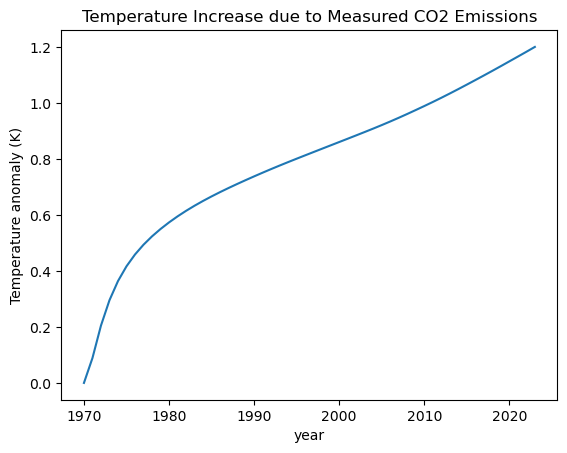

In [200]:
plt.plot(f.timebounds, f.temperature.loc[dict(scenario='s1', layer=0)])
plt.xlabel('year')
plt.ylabel('Temperature anomaly (K)')
plt.title('Temperature Increase due to Measured CO2 Emissions')
plt.show()

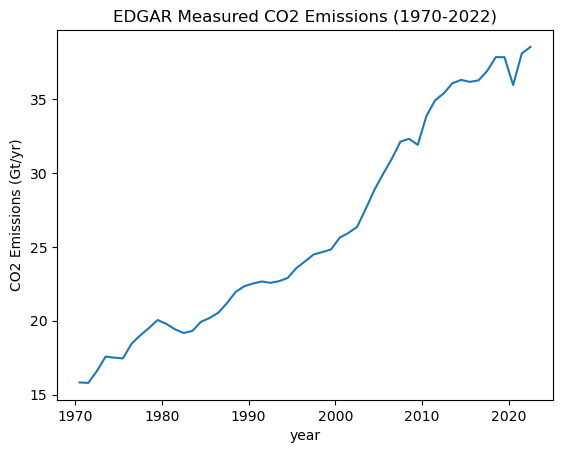

In [201]:
plt.plot(f.timepoints, f.emissions.sel(specie='CO2').squeeze())
plt.xlabel('year')
plt.ylabel('CO2 Emissions (Gt/yr)')
plt.title('EDGAR Measured CO2 Emissions (1970-2022)')
plt.show()

## Takeaway- UNITS MATTER

The EDGAR CO2 dataset expresses emissions in Gg CO2/yr, while FaIR has units of Gt CO2/yr. This meant that before adjustments, emissions were 1 million times higher than they should have been, and warming was up to 700 K...

Luckily, this was an obvious mistake due to the massive magnitude adjustment needed. However, it's a good lesson to keep in mind. If ever uncertain about units, refer to the FaIR [documentation](https://docs.fairmodel.net/en/latest/api_reference.html#module-fair) or run `structure.units.desired_emissions_units`, `structure.units.desired_concentration_units`

In [202]:
from fair import structure
structure.units.desired_emissions_units

{'CO2 FFI': 'Gt CO2/yr',
 'CO2 AFOLU': 'Gt CO2/yr',
 'CO2': 'Gt CO2/yr',
 'CH4': 'Mt CH4/yr',
 'N2O': 'Mt N2O/yr',
 'Sulfur': 'Mt SO2/yr',
 'BC': 'Mt BC/yr',
 'OC': 'Mt OC/yr',
 'NH3': 'Mt NH3/yr',
 'NOx': 'Mt NO2/yr',
 'VOC': 'Mt VOC/yr',
 'CO': 'Mt CO/yr',
 'CFC-11': 'kt CFC11/yr',
 'CFC-12': 'kt CFC12/yr',
 'CFC-113': 'kt CFC113/yr',
 'CFC-114': 'kt CFC114/yr',
 'CFC-115': 'kt CFC115/yr',
 'HCFC-22': 'kt HCFC22/yr',
 'HCFC-141b': 'kt HCFC141b/yr',
 'HCFC-142b': 'kt HCFC142b/yr',
 'CCl4': 'kt CCl4/yr',
 'CHCl3': 'kt CHCl3/yr',
 'CH2Cl2': 'kt CH2Cl2/yr',
 'CH3Cl': 'kt CH3Cl/yr',
 'CH3CCl3': 'kt CH3CCl3/yr',
 'CH3Br': 'kt CH3Br/yr',
 'Halon-1202': 'kt Halon1202/yr',
 'Halon-1211': 'kt Halon1211/yr',
 'Halon-1301': 'kt Halon1301/yr',
 'Halon-2402': 'kt Halon2402/yr',
 'CF4': 'kt CF4/yr',
 'C2F6': 'kt C2F6/yr',
 'C3F8': 'kt C3F8/yr',
 'c-C4F8': 'kt cC4F8/yr',
 'C4F10': 'kt C4F10/yr',
 'C5F12': 'kt C5F12/yr',
 'C6F14': 'kt C6F14/yr',
 'C7F16': 'kt C7F16/yr',
 'C8F18': 'kt C8F18/yr',
 'NF3